### Kaggle bootstrapping

In [1]:
# Kaggle COMPETITION bootstrapping
COMPETITION_NAME = 'nlp-getting-started'

!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

models	sample_submission.csv  test.csv  train.csv


### Explore the data

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [5]:
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [6]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [7]:
df.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [8]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# sample non-disaster tweet
df[df.target == 0].text.values[0]

"What's up man?"

In [10]:
# sample disaster tweet
df[df.target == 1].text.values[1]

'Forest fire near La Ronge Sask. Canada'

### Data cleanup

In [11]:
# TODO

### Preprocess the data

In [12]:
df['text_len'] = df.text.str.len()
df

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137


In [13]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len'], dtype='object')

### Let's use transformers now!

In [17]:
!pip install -Uqq transformers

In [18]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [19]:
from fastai.text.all import *

In [20]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [21]:
all_texts = df.text.values
all_texts

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all', 'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'], dtype=object)

In [30]:
RandomSplitter?

Signature: RandomSplitter(valid_pct=0.2, seed=None)
Docstring: Create function that splits `items` between train/val with `valid_pct` randomly.
File:      /usr/local/lib/python3.9/dist-packages/fastai/data/transforms.py
Type:      function


In [37]:
splits = RandomSplitter()(all_texts)

In [38]:
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
tls

TfmdLists: ['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all' 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 ... 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ'
 'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.'
 'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d']
tfms - [TransformersTokenizer:
encodes: (object,object) -> encodes
decodes: (object,object) -> decodes
]

In [39]:
tls.train[0],tls.valid[0]

(tensor([   31,    81,    62,  5031, 23532,  5999, 19104,  2488,    87, 13210,
         36920, 49173, 17464,  1312,  2911,   345,   651,  6577, 12523, 14476,
           276,  8591, 23532]),
 tensor([   13,  2488, 18697,  8068,   395, 26459, 36903,   706,  3596,   734,
           338,  3257,  6193, 24663,    25,  2638,  1378,    83,    13,  1073,
            14, 10246,  2713,    68,    51,    75,    42,    22,    83,  2638,
          1378,    83,    13,  1073,    14,    18, 30098,    23,    44, 12337,
          5868,    64]))

In [49]:
tls.train.items.shape, tls.valid.items.shape

((6091,), (1522,))

In [50]:
show_at(tls.train, 0)

@r_lauren83199 @xojademarie124 i hope you get Batista Bombed lauren


In [44]:
show_at(tls.valid, 0)

. @VELDFest announces refunds after Day two's extreme weather evacuation: http://t.co/PP05eTlK7t http://t.co/3Ol8MhhPMa


In [51]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [53]:
dls.show_batch(max_n=2)

,text,text_
0,Experienced urogyn trying to help mesh injured women talks the worst offenders. http://t.co/NpOQLkqUP9 @meshnewsdesk@AmirKingKhan you would have been annihilated so you might as well thank @FloydMayweatherThere's a weird siren going off here...I hope Hunterston isn't in the process of blowing itself to smithereens...Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Dbcpwd9uCrying out for more! Set me ablazeCheck out my Lava lamp dude???? http://t.co/To9ViqooFvBeware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!I added a video to a @YouTube playlist http://t.co/QsEkoeuBMd Panic! At The Disco: Girls/Girls/Boys [OFFICIAL VIDEO]@author_mike Amen today is the Day of Salvation. THX brother Mike for your great encouragement. - http://t.co/cybKsXHF7d,ienced urogyn trying to help mesh injured women talks the worst offenders. http://t.co/NpOQLkqUP9 @meshnewsdesk@AmirKingKhan you would have been annihilated so you might as well thank @FloydMayweatherThere's a weird siren going off here...I hope Hunterston isn't in the process of blowing itself to smithereens...Fascinating pics from inside North Korea. Not propaganda not devastation - just people living life. http://t.co/E2Dbcpwd9uCrying out for more! Set me ablazeCheck out my Lava lamp dude???? http://t.co/To9ViqooFvBeware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!I added a video to a @YouTube playlist http://t.co/QsEkoeuBMd Panic! At The Disco: Girls/Girls/Boys [OFFICIAL VIDEO]@author_mike Amen today is the Day of Salvation. THX brother Mike for your great encouragement. - http://t.co/cybKsXHF7d Coming
1,filipino#dam #gms Olap #world pres: http://t.co/mIcjNPuhG0 How To Recognize A Hazardous Waste And The Multidimensional http://t.co/Vddi5ChKTPPetition to remaster Fatal Frame 1 with a Windwaker-style selfie modeWhen high fashion and food collide: Gucci has chosen one of ShanghaiÛªs most popular commercial avenue... http://t.co/MkRxQZeHmY #fashionThings you CAN pick up from tozlet seat|: butt leprosy full-blown jerkface syndrome a lateral lisp &amp; toilet rickets.My ears are bleeding https://t.co/k5KnNwugwT@Bardissimo Yes life has a 100% fatality rate.New post: 'People are finally panicking about cable TV' http://t.co/pkfV8lkSlD@Adumbbb oh that's not too bad then haha. I would've been panicking tho.I can't listen to Darude Sandstorm without expecting airhorns now@danisnotonfire if you follow me I will,ipino#dam #gms Olap #world pres: http://t.co/mIcjNPuhG0 How To Recognize A Hazardous Waste And The Multidimensional http://t.co/Vddi5ChKTPPetition to remaster Fatal Frame 1 with a Windwaker-style selfie modeWhen high fashion and food collide: Gucci has chosen one of ShanghaiÛªs most popular commercial avenue... http://t.co/MkRxQZeHmY #fashionThings you CAN pick up from tozlet seat|: butt leprosy full-blown jerkface syndrome a lateral lisp &amp; toilet rickets.My ears are bleeding https://t.co/k5KnNwugwT@Bardissimo Yes life has a 100% fatality rate.New post: 'People are finally panicking about cable TV' http://t.co/pkfV8lkSlD@Adumbbb oh that's not too bad then haha. I would've been panicking tho.I can't listen to Darude Sandstorm without expecting airhorns now@danisnotonfire if you follow me I will go


In [54]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [55]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [56]:
learn.validate()

(#2) [5.085115909576416,161.59866333007812]

SuggestedLRs(valley=0.00010964782268274575)

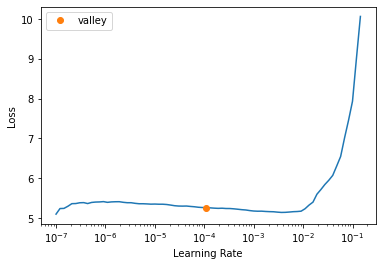

In [57]:
learn.lr_find()

In [58]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.634075,4.450113,85.636604,01:28


In [59]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,4.332619,4.353981,77.787483,01:28


In [73]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [74]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [75]:
print(torch.cuda.list_gpu_processes())

GPU:0
process      20172 uses     2875.000 MB GPU memory
process      22648 uses     8675.000 MB GPU memory


### Not bad, but now we want to classify lol

In [100]:
from transformers import GPT2Model
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2Model.from_pretrained(pretrained_weights)

In [101]:
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits)

In [102]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [103]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=accuracy).to_fp16()

In [104]:
learn.validate()

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 166, in create_batch
    try: return (fa_collate,fa_convert)[self.prebatched](b)
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 51, in fa_collate
    return (default_collate(t) if isinstance(b, _collate_types)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/collate.py", line 140, in default_collate
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 140, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 170, in do_batch
    def do_batch(self, b): return self.retain(self.create_batch(self.before_batch(b)), b)
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 168, in create_batch
    if not self.prebatched: collate_error(e,b)
  File "/usr/local/lib/python3.9/dist-packages/fastai/data/load.py", line 76, in collate_error
    elif item[idx].shape != shape_a:
IndexError: index 24 is out of bounds for dimension 0 with size 24


In [91]:
learn.lr_find()

ValueError: Expected input batch_size (260) to match target batch_size (4).

In [73]:
learn.fine_tune(6, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.603722,0.508554,0.755585,00:04


epoch,train_loss,valid_loss,accuracy,time
0,0.550142,0.464505,0.784494,00:08
1,0.508443,0.444130,0.810118,00:08
2,0.470107,0.427745,0.819317,00:08
3,0.417554,0.438105,0.815374,00:08
4,0.388944,0.437513,0.825230,00:08
5,0.347978,0.434288,0.828515,00:09


In [74]:
learn.show_results()

,text,category,category_
0,xxbos xxup info xxup s. xxup wnd : xxunk / 6 . xxup xxunk : xxup xxunk xxup xxunk . xxup exp xxup inst xxup apch . xxup rwy 05 . xxup curfew xxup in xxup oper xxup until 2030 xxup z. xxup taxiways xxup foxtrot 5 & & xxup foxtrot 6 xxup navbl . xxup tmp : 10 .,0,0
1,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
2,xxbos xxmaj truth … \n https : / / t.co / xxunk \n▁ # xxmaj news \n▁ # xxup bbc \n▁ # xxup cnn \n▁ # xxmaj islam \n▁ # xxmaj truth \n▁ # god \n▁ # xxup isis \n▁ # terrorism \n▁ # xxmaj quran \n▁ # xxmaj lies http : / / t.co / xxunk,1,1
3,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxup xxunk xxmaj please # xxup rt,0,0
4,xxbos xxmaj learn xxmaj how i xxmaj gained xxmaj access xxmaj to xxmaj the xxmaj secrets xxmaj of xxmaj the xxmaj top xxmaj earners & & xxmaj used xxmaj them xxmaj to xxmaj explode xxmaj my xxmaj home xxmaj business xxmaj here : http : / / t.co / xxunk xxmaj please # xxup rt,0,0
5,xxbos xxmaj the xxmaj fake of xxmaj xxunk xxmaj xxunk xxmaj xxunk ( english ): http : / / t.co / xxunk # xxmaj obama # xxmaj clinton # xxmaj bush # xxup gop # xxup abc # xxup xxunk # xxup bbc # xxup cnn # xxup xxunk # xxup xxunk,1,0
6,xxbos xxmaj morgan xxmaj silver xxmaj dollar xxunk p xxup xxunk xxmaj gem xxmaj bu xxup xxunk xxmaj blazing xxup ms xxrep 6 + xxmaj xxunk xxmaj rare xxmaj proof xxmaj like ! - xxmaj full reû _ http : / / t.co / xxunk http : / / t.co / xxunk,0,0
7,xxbos xxmaj xxunk xxmaj hot xxmaj deals # xxunk > > http : / / t.co / xxunk xxunk xxunk xxunk xxunk xxup led xxmaj work xxmaj light xxup flood xxmaj lamp xxmaj xxunk xxmaj truck xxup suv xxup xxunk xxup aû _ http : / / t.co / xxunk,0,0
8,xxbos # nowplaying * xxmaj cliff xxmaj richard - i xxmaj could xxmaj easily xxmaj fall ( in xxmaj love xxmaj with xxmaj you ) ( & & xxmaj xxunk ) * # xxmaj internet # xxmaj xxunk # xxmaj radio xxmaj on http : / / t.co / xxunk,0,0


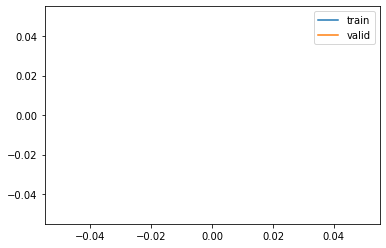

In [75]:
learn.recorder.plot_loss()

### predictions for test data

In [76]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [77]:
test_dl = dls.test_dl(test_df)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [78]:
decoded.shape

torch.Size([3263])

In [82]:
decoded.float().mean()

tensor(0.3721)

### Submission

In [83]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

(3263, 2)

In [84]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [85]:
submission.target = decoded
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [86]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### send submission to Kaggle!

In [87]:
# write submission csv
technique = 'large-fastai-learner'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/nlp-getting-started-large-fastai-learner-sub.csv to kaggle


continue? y


100%|██████████| 22.2k/22.2k [00:00<00:00, 37.8kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets
